In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# define fixed parameters

#conductances
C_m = 1.0e-9

# volatages
V_leak = -40.0e-3 # 40 mV
V_Ca = 100.0e-3 # 100mV
V_k = -80.0e-3 # -80mV
V_h = -20.0e-3 # -20mV
V_syn = -75.0e-3 # -75mV

v_1 = 0.0 # 0mV
v_2 = 20.0e-3 # 20mV
v_3 = 0.0 # 0mV
v_4 = 15.0e-3 # 15mV
v_5 = 78.3e-3 # 78.3mV
v_6 = 10.5e-3 # 10.5mV
v_7 = -42.2e-3 # -42.2mV
v_8 = 87.3e-3 # 87.3mV
v_9 = 5.0e-3  # 5.0mV

v_th = -25.0e-3 # -25mV

# neuron specific conductances
g_Ca_f = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_Ca_h = 1.7e-2 * (1e-6) # 1.7e-2 \mu S
g_Ca_s = 8.5e-3 * (1e-6) # 8.5e-3 \mu S

g_k_f  = 3.9e-2 * (1e-6) # 3.9e-2 \mu S
g_k_h  = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_k_s  = 1.5e-2 * (1e-6) # 1.5e-2 \mu S

g_h_f  = 2.5e-2 * (1e-6) # 2.5e-2 \mu S
g_h_h  = 8.0e-3 * (1e-6) # 8.0e-3 \mu S
g_h_s  = 1.0e-2 * (1e-6) # 1.0e-2 \mu S

g_Ca = np.array([g_Ca_f, g_Ca_f, g_Ca_h, g_Ca_s, g_Ca_s])
g_k = np.array([g_k_f, g_k_f, g_k_h, g_k_s, g_k_s])
g_h = np.array([g_h_f, g_h_f, g_h_h, g_h_s, g_h_s])

g_leak = 1.0e-4 * (1e-6) # 1e-4 \mu S

phi_N = 2 # 0.002 ms^-1


    

## state representation

The state variable $x$ is comprised of three, five-dimensional state variables ($V_m$, $N$, and $H$) for each neuron.

$$x = \begin{bmatrix} V_m \\ N \\ H \end{bmatrix}$$
$$V_m = \begin{bmatrix} V_{m,f_1} \\ V_{m,f_2} \\ V_{m,h_n} \\ V_{m,s_1} \\ V_{m,s_2} \end{bmatrix} \hspace{1cm}
N = \begin{bmatrix} N_{f_1} \\ N_{f_2} \\ N_{h_n} \\ N_{s_1} \\ N_{s_2} \end{bmatrix} \hspace{1cm}
H = \begin{bmatrix} H_{f_1} \\ H_{f_2} \\ H_{h_n} \\ H_{s_1} \\ H_{s_2} \end{bmatrix} 
$$

In [3]:
def f(x, g_el, g_synA, g_synB):
    # x contains
    V_m = x[:5]
    N = x[5:10]
    H = x[10:]
    
    M_inf = 0.5*(1.0 + np.tanh((V_m - v_1)/ v_2))
    N_inf = 0.5*(1.0 + np.tanh((V_m - v_3)/v_4))
    H_inf = 1.0 / (1.0 + np.exp((V_m + v_5)/v_6))
                   
    S_inf = 1.0 / (1.0 + np.exp((v_th - V_m) / v_9))
    
    I_leak = g_leak*(V_m - V_leak)
    I_Ca = g_Ca*M_inf*(V_m - V_Ca)
    I_k = g_k*N*(V_m - V_k)
    I_h = g_h*H*(V_m - V_h)
                   
    I_elec = np.array([0.0, 
                       g_el*(V_m[1]-V_m[2]),
                       g_el*(V_m[2]-V_m[1] + V_m[2]-V_m[4]),
                       0.0,
                       g_el*(V_m[4]-V_m[2])])
                   
    I_syn = np.array([g_synB*S_inf[1]*(V_m[0] - V_syn),
                        g_synB*S_inf[0]*(V_m[1] - V_syn),
                        g_synA*S_inf[0]*(V_m[2] - V_syn) + g_synA*S_inf[3]*(V_m[2] - V_syn),
                        g_synB*S_inf[4]*(V_m[3] - V_syn),
                        g_synB*S_inf[3]*(V_m[4] - V_syn)])

    I_total = I_leak + I_Ca + I_k + I_h + I_elec + I_syn    
    
    lambda_N = (phi_N)*np.cosh((V_m - v_3)/(2*v_4))
    tau_h = (272.0 - (-1499.0 / (1.0 + np.exp((-V_m + v_7) / v_8)))) / 1000.0
    
    dVmdt = (1.0 / C_m)*(-I_total)
    dNdt = lambda_N*(N_inf - N)
    dHdt = (H_inf - H) / tau_h
    
    dxdt = np.concatenate((dVmdt, dNdt, dHdt), axis=0)
    return dxdt            

In [4]:
# parameters for the DSN
g_el = np.arange(0.1, 8.0, 0.25) * (1e-9) # .25 nS  (.25-7.5 nS) range
g_synA = np.arange(0.1, 8.0, 0.25) * (1e-9) # .25 nS  (.25-10 nS) range
g_synB = 5.0 * (1e-9) # .25 nS  (.25-10 nS) range

num_g_el = g_el.shape[0]
num_g_synA = g_synA.shape[0]

In [22]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

V_m0 = -65.0e-3*np.ones((5,))
N_0 = 0.25*np.ones((5,))
H_0 = 0.1*np.ones((5,))

x0 = np.array([-0.04169771, -0.04319491,  0.00883992, -0.06879824,  0.03048103,
               0.00151316, 0.19784773, 0.56514935, 0.12214069, 0.35290397,
               0.08614699, 0.04938177, 0.05568701, 0.07007949, 0.05790969])

x = x0
T = 210
fft_start = 0
dt = 0.025

w = 20

N = T - fft_start + 1 - (w-1) 

Fs = 1.0 / dt

phi_ts = []
min_freq = 0.0
max_freq = 1.0
num_freqs = 101
freqs = np.linspace(min_freq, max_freq, num_freqs)

ns = np.arange(0,N)
for i in range(num_freqs):
    freq_i = freqs[i]
    k = N*freq_i / Fs
    phi_t = np.cos(2*np.pi*k*ns/N) - 1j * np.sin(2*np.pi*k*ns/N)
    phi_ts.append(phi_t)
    
Phi = np.array(phi_ts)

In [25]:
max_freqs = np.zeros((num_g_el, num_g_synA))
for i in range(num_g_el):
    for j in range(num_g_synA):
        print(i,j,g_el[i], g_synA[j])
        start_time = time.time()
        x = x0
        xs = [x0]
        for t in range(T):
            dxdt = f(x, g_el[i], g_synA[j], g_synB)
            x = dxdt*dt + x
            xs.append(x)
        X = np.array(xs)
        X_end = X[fft_start:,2]
        #plt.figure()
        #plt.plot(X_end)
        #plt.show()
        X_rect = np.maximum(X_end, -.01)
        X_rect_LPF = moving_average(X_rect, w)
        #X_rect_LPF = X_rect_LPF - np.mean(X_rect_LPF)
        Xk = np.dot(Phi, X_rect_LPF)
        #plt.figure()
        #plt.plot(np.abs(Xk))
        #plt.title('X_k')
        plt.show()
        ind = np.argmax(np.abs(Xk))
        
        max_freqs[i,j] = freqs[ind]
        print('took', time.time() - start_time)

0 0 1.0000000000000002e-10 1.0000000000000002e-10
took 0.016597986221313477
0 1 1.0000000000000002e-10 3.5e-10
took 0.016154766082763672
0 2 1.0000000000000002e-10 6e-10
took 0.01674485206604004
0 3 1.0000000000000002e-10 8.5e-10
took 0.01459193229675293
0 4 1.0000000000000002e-10 1.1e-09
took 0.012849092483520508
0 5 1.0000000000000002e-10 1.3499999999999999e-09
took 0.014479875564575195
0 6 1.0000000000000002e-10 1.6e-09
took 0.012292861938476562
0 7 1.0000000000000002e-10 1.85e-09
took 0.01320195198059082
0 8 1.0000000000000002e-10 2.0999999999999998e-09
took 0.012766122817993164
0 9 1.0000000000000002e-10 2.35e-09
took 0.011985063552856445
0 10 1.0000000000000002e-10 2.5999999999999997e-09
took 0.012234926223754883
0 11 1.0000000000000002e-10 2.85e-09
took 0.013488054275512695
0 12 1.0000000000000002e-10 3.0999999999999996e-09
took 0.013311147689819336
0 13 1.0000000000000002e-10 3.35e-09
took 0.013007879257202148
0 14 1.0000000000000002e-10 3.6e-09
took 0.012710094451904297
0 15 1

took 0.01255178451538086
4 15 1.1e-09 3.85e-09
took 0.013122797012329102
4 16 1.1e-09 4.0999999999999995e-09
took 0.014348983764648438
4 17 1.1e-09 4.349999999999999e-09
took 0.013533353805541992
4 18 1.1e-09 4.599999999999999e-09
took 0.013231277465820312
4 19 1.1e-09 4.849999999999999e-09
took 0.01270914077758789
4 20 1.1e-09 5.099999999999999e-09
took 0.014739990234375
4 21 1.1e-09 5.349999999999999e-09
took 0.014418840408325195
4 22 1.1e-09 5.599999999999999e-09
took 0.017701148986816406
4 23 1.1e-09 5.8499999999999994e-09
took 0.01687002182006836
4 24 1.1e-09 6.099999999999999e-09
took 0.013107061386108398
4 25 1.1e-09 6.349999999999999e-09
took 0.013930320739746094
4 26 1.1e-09 6.5999999999999995e-09
took 0.01278996467590332
4 27 1.1e-09 6.849999999999999e-09
took 0.01395106315612793
4 28 1.1e-09 7.099999999999999e-09
took 0.012212038040161133
4 29 1.1e-09 7.349999999999999e-09
took 0.013273954391479492
4 30 1.1e-09 7.599999999999999e-09
took 0.012880802154541016
4 31 1.1e-09 7.8

took 0.014919042587280273
8 29 2.0999999999999998e-09 7.349999999999999e-09
took 0.013555049896240234
8 30 2.0999999999999998e-09 7.599999999999999e-09
took 0.013228893280029297
8 31 2.0999999999999998e-09 7.849999999999999e-09
took 0.013005971908569336
9 0 2.35e-09 1.0000000000000002e-10
took 0.015793800354003906
9 1 2.35e-09 3.5e-10
took 0.01583123207092285
9 2 2.35e-09 6e-10
took 0.014467954635620117
9 3 2.35e-09 8.5e-10
took 0.016156911849975586
9 4 2.35e-09 1.1e-09
took 0.016766786575317383
9 5 2.35e-09 1.3499999999999999e-09
took 0.016292810440063477
9 6 2.35e-09 1.6e-09
took 0.018536806106567383
9 7 2.35e-09 1.85e-09
took 0.017565250396728516
9 8 2.35e-09 2.0999999999999998e-09
took 0.017590045928955078
9 9 2.35e-09 2.35e-09
took 0.01570582389831543
9 10 2.35e-09 2.5999999999999997e-09
took 0.016568899154663086
9 11 2.35e-09 2.85e-09
took 0.016164064407348633
9 12 2.35e-09 3.0999999999999996e-09
took 0.01657700538635254
9 13 2.35e-09 3.35e-09
took 0.016200780868530273
9 14 2.35e

took 0.016144990921020508
12 28 3.0999999999999996e-09 7.099999999999999e-09
took 0.016312837600708008
12 29 3.0999999999999996e-09 7.349999999999999e-09
took 0.015475988388061523
12 30 3.0999999999999996e-09 7.599999999999999e-09
took 0.016112804412841797
12 31 3.0999999999999996e-09 7.849999999999999e-09
took 0.016356229782104492
13 0 3.35e-09 1.0000000000000002e-10
took 0.01708507537841797
13 1 3.35e-09 3.5e-10
took 0.017534971237182617
13 2 3.35e-09 6e-10
took 0.017010927200317383
13 3 3.35e-09 8.5e-10
took 0.01835799217224121
13 4 3.35e-09 1.1e-09
took 0.016686201095581055
13 5 3.35e-09 1.3499999999999999e-09
took 0.016473054885864258
13 6 3.35e-09 1.6e-09
took 0.015697002410888672
13 7 3.35e-09 1.85e-09
took 0.016551971435546875
13 8 3.35e-09 2.0999999999999998e-09
took 0.016843080520629883
13 9 3.35e-09 2.35e-09
took 0.016832828521728516
13 10 3.35e-09 2.5999999999999997e-09
took 0.01740431785583496
13 11 3.35e-09 2.85e-09
took 0.017815828323364258
13 12 3.35e-09 3.0999999999999

took 0.017460107803344727
17 11 4.349999999999999e-09 2.85e-09
took 0.017032861709594727
17 12 4.349999999999999e-09 3.0999999999999996e-09
took 0.016607999801635742
17 13 4.349999999999999e-09 3.35e-09
took 0.017024993896484375
17 14 4.349999999999999e-09 3.6e-09
took 0.016499996185302734
17 15 4.349999999999999e-09 3.85e-09
took 0.016217708587646484
17 16 4.349999999999999e-09 4.0999999999999995e-09
took 0.013082265853881836
17 17 4.349999999999999e-09 4.349999999999999e-09
took 0.01311492919921875
17 18 4.349999999999999e-09 4.599999999999999e-09
took 0.013176918029785156
17 19 4.349999999999999e-09 4.849999999999999e-09
took 0.013036966323852539
17 20 4.349999999999999e-09 5.099999999999999e-09
took 0.014251947402954102
17 21 4.349999999999999e-09 5.349999999999999e-09
took 0.013588905334472656
17 22 4.349999999999999e-09 5.599999999999999e-09
took 0.015583992004394531
17 23 4.349999999999999e-09 5.8499999999999994e-09
took 0.015909194946289062
17 24 4.349999999999999e-09 6.0999999

took 0.013091087341308594
21 10 5.349999999999999e-09 2.5999999999999997e-09
took 0.013011932373046875
21 11 5.349999999999999e-09 2.85e-09
took 0.013726949691772461
21 12 5.349999999999999e-09 3.0999999999999996e-09
took 0.013715028762817383
21 13 5.349999999999999e-09 3.35e-09
took 0.012251138687133789
21 14 5.349999999999999e-09 3.6e-09
took 0.013406991958618164
21 15 5.349999999999999e-09 3.85e-09
took 0.012951850891113281
21 16 5.349999999999999e-09 4.0999999999999995e-09
took 0.013033151626586914
21 17 5.349999999999999e-09 4.349999999999999e-09
took 0.01302194595336914
21 18 5.349999999999999e-09 4.599999999999999e-09
took 0.01228785514831543
21 19 5.349999999999999e-09 4.849999999999999e-09
took 0.012745857238769531
21 20 5.349999999999999e-09 5.099999999999999e-09
took 0.012471675872802734
21 21 5.349999999999999e-09 5.349999999999999e-09
took 0.012579917907714844
21 22 5.349999999999999e-09 5.599999999999999e-09
took 0.013019084930419922
21 23 5.349999999999999e-09 5.84999999

took 0.01226496696472168
25 6 6.349999999999999e-09 1.6e-09
took 0.013529062271118164
25 7 6.349999999999999e-09 1.85e-09
took 0.014050006866455078
25 8 6.349999999999999e-09 2.0999999999999998e-09
took 0.013827085494995117
25 9 6.349999999999999e-09 2.35e-09
took 0.01385498046875
25 10 6.349999999999999e-09 2.5999999999999997e-09
took 0.01254415512084961
25 11 6.349999999999999e-09 2.85e-09
took 0.013485193252563477
25 12 6.349999999999999e-09 3.0999999999999996e-09
took 0.01278376579284668
25 13 6.349999999999999e-09 3.35e-09
took 0.01258993148803711
25 14 6.349999999999999e-09 3.6e-09
took 0.013126134872436523
25 15 6.349999999999999e-09 3.85e-09
took 0.012572288513183594
25 16 6.349999999999999e-09 4.0999999999999995e-09
took 0.012431144714355469
25 17 6.349999999999999e-09 4.349999999999999e-09
took 0.01267099380493164
25 18 6.349999999999999e-09 4.599999999999999e-09
took 0.012794971466064453
25 19 6.349999999999999e-09 4.849999999999999e-09
took 0.01300811767578125
25 20 6.34999

took 0.012766838073730469
29 5 7.349999999999999e-09 1.3499999999999999e-09
took 0.01280522346496582
29 6 7.349999999999999e-09 1.6e-09
took 0.013254880905151367
29 7 7.349999999999999e-09 1.85e-09
took 0.013841867446899414
29 8 7.349999999999999e-09 2.0999999999999998e-09
took 0.013210773468017578
29 9 7.349999999999999e-09 2.35e-09
took 0.013705253601074219
29 10 7.349999999999999e-09 2.5999999999999997e-09
took 0.013188838958740234
29 11 7.349999999999999e-09 2.85e-09
took 0.01335287094116211
29 12 7.349999999999999e-09 3.0999999999999996e-09
took 0.014058113098144531
29 13 7.349999999999999e-09 3.35e-09
took 0.013982057571411133
29 14 7.349999999999999e-09 3.6e-09
took 0.014205217361450195
29 15 7.349999999999999e-09 3.85e-09
took 0.013502836227416992
29 16 7.349999999999999e-09 4.0999999999999995e-09
took 0.013749837875366211
29 17 7.349999999999999e-09 4.349999999999999e-09
took 0.01334524154663086
29 18 7.349999999999999e-09 4.599999999999999e-09
took 0.013139009475708008
29 19 

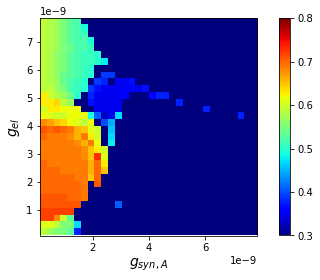

In [29]:
fig = plt.figure(figsize=(8,4))
plt.imshow(max_freqs, origin='lower', vmin=0.3, vmax=0.8, cmap='jet', extent=[g_synA[0], g_synA[-1], g_el[0], g_el[-1]])
ax = plt.gca()
plt.colorbar()
plt.xlabel(r'$g_{syn,A}$', fontsize=fontsize)
plt.ylabel(r'$g_{el}$', fontsize=fontsize)
plt.show()

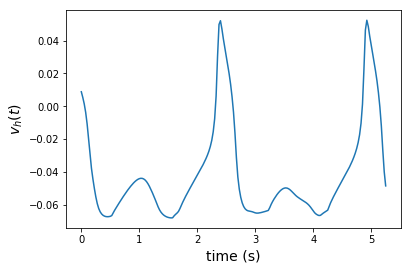

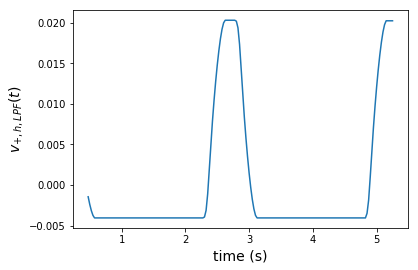

In [28]:
fontsize = 14
t = dt*np.arange(0, T+1)
v_h = X[:,2]
plt.figure()
plt.plot(t, v_h)
plt.xlabel('time (s)', fontsize=fontsize)
plt.ylabel(r'$v_h(t)$', fontsize=fontsize)
plt.show()

v_h_end = v_h[fft_start:]
v_h_rect = np.maximum(v_h_end, -0.01)
v_h_rect_LPF = moving_average(v_h_rect, w)
v_h_rect_LPF = v_h_rect_LPF - np.mean(v_h_rect_LPF)

t_end = dt*np.arange(fft_start+w-1, T+1)
plt.figure()
plt.plot(t_end, v_h_rect_LPF)
plt.xlabel('time (s)', fontsize=fontsize)
plt.ylabel(r'$v_{+,h,LPF}(t)$', fontsize=fontsize)
plt.show()

In [30]:
# parameters for the DSN
g_el = np.array([1.0])*1e-9
g_synA = np.array([2.0])*1e-9
g_synB = 5.0 * (1e-9) # .25 nS  (.25-10 nS) range

num_g_el = g_el.shape[0]
num_g_synA = g_synA.shape[0]

1e-09 2e-09


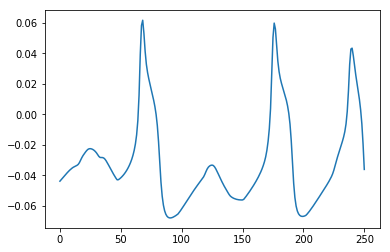

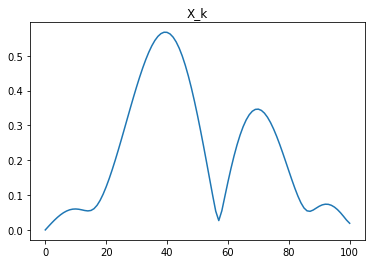

0 0 0.39
took 0.27952003479003906


In [31]:

V_m0 = -65.0e-3*np.ones((5,))
N_0 = 0.25*np.ones((5,))
H_0 = 0.1*np.ones((5,))
x0 = np.concatenate((V_m0, N_0, H_0), axis=0)
x = x0
T = 290
fft_start = 40
dt = 0.025

w = 40

N = T - fft_start + 1 - (w-1) 

Fs = 1.0 / dt

phi_ts = []
min_freq = 0.0
max_freq = 1.0
num_freqs = 101
freqs = np.linspace(min_freq, max_freq, num_freqs)

ns = np.arange(0,N)
for i in range(num_freqs):
    freq_i = freqs[i]
    k = N*freq_i / Fs
    phi_t = np.cos(2*np.pi*k*ns/N) - 1j * np.sin(2*np.pi*k*ns/N)
    phi_ts.append(phi_t)
    
Phi = np.array(phi_ts)

max_freqs = np.zeros((num_g_el, num_g_synA))
for i in range(num_g_el):
    for j in range(num_g_synA):
        print(g_el[i], g_synA[j])
        start_time = time.time()
        xs = [x0]
        for t in range(T):
            dxdt = f(x, g_el[i], g_synA[j], g_synB)
            x = dxdt*dt + x
            xs.append(x)
        X = np.array(xs)
        X_end = X[fft_start:,2]
        plt.figure()
        plt.plot(X_end)
        plt.show()
        X_rect = np.maximum(X_end, 0.0)
        X_rect_LPF = moving_average(X_rect, w)
        X_rect_LPF = X_rect_LPF - np.mean(X_rect_LPF)
        Xk = np.dot(Phi, X_rect_LPF)
        plt.figure()
        plt.plot(np.abs(Xk))
        plt.title('X_k')
        plt.show()
        ind = np.argmax(np.abs(Xk))
        
        max_freqs[i,j] = freqs[ind]
        print(i,j,freqs[ind])
        print('took', time.time() - start_time)